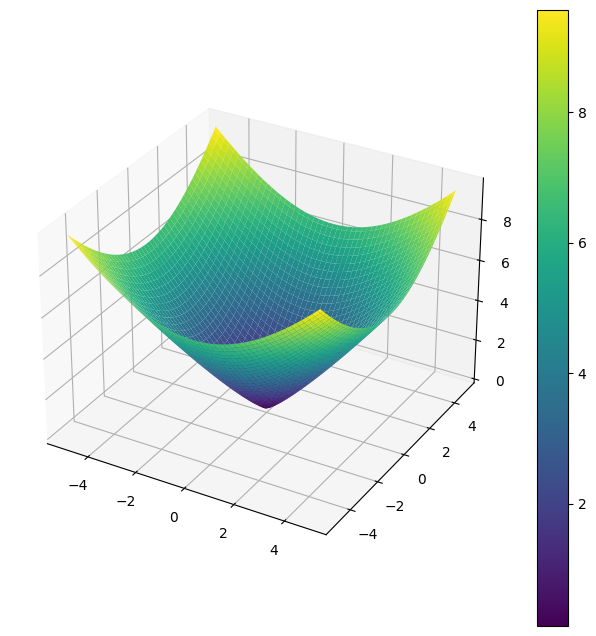

In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
import torch.nn as nn
from tqdm import tqdm
import pandas as pd


import task1

#-----------------------------------------------------------------------------
# Define function to be approximated.

def funToApprox(x): # x is a set of tuples (x1, x2).
    x1 = x[:, 0]
    x2 = x[:, 1]
    return task1.target_fct(x1, x2)
#-----------------------------------------------------------------------------
# Make a training dataset.

## To do: Define x1 and x2 tensors individually as described in the problem set: [-5, -4.9, ..., 4.8, 4.9, 5.0]. 
## Hint: Use torch.arange() and step_size.
x1 = torch.arange(-5, 5, 0.1)
x2 = torch.arange(-5, 5, 0.1)
x1_grid, x2_grid = torch.meshgrid(x1, x2, indexing='ij') 


x_train = torch.cartesian_prod(x1, x2).reshape(-1,2) 
#print(x_train)
y_train = funToApprox(x_train) 


dataset_train = torch.cat((x_train, y_train), dim=1)



#-----------------------------------------------------------------------------
# Plot the function in 3D. 
## To do: Rreshape y_train appropriately to plot the figure. 
y_train_plot = y_train.reshape(100, 100)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(x1_grid, x2_grid, y_train_plot, cmap='viridis')
fig.colorbar(surf, ax=ax)


In [6]:
#-----------------------------------------------------------------------------
## To do: Choose proper hyper parameters.
# Number of hidden nodes
N1 = 12
# Number of epochs for training
epochs = int(2e3)
# Period of printing loss (epochs)
print_loss_every = 100
# Learning rate for training
learning_rate = 0.1

#-----------------------------------------------------------------------------
# Get cpu, gpu or mps device for training. 
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device \n")

#-----------------------------------------------------------------------------
# Define a neural network model.
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        ## To do: Fill out the arguments and activation function to define the 2-layer perceptron. 
        self.linear_sigm = nn.Sequential(
            nn.Linear(2, N1), # input layer
            nn.Sigmoid(), # activation function
            nn.Linear(N1, 1) # output layer
        )
    
    def forward(self, x):
        yhat = self.linear_sigm(x)
        return yhat

model = NeuralNetwork().to(device) 

# Parameter initialization.
for param in model.parameters():
    param.data.normal_(mean=0.0, std=1.0)

print("Defined neural network model: \n")
print(model)
print("\n")


Using cpu device 

Defined neural network model: 

NeuralNetwork(
  (linear_sigm): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=12, out_features=1, bias=True)
  )
)




In [7]:

def shuffle_dataset(dataset_train):
    
    # Shuffle the dataset.
    dataset_train = dataset_train[torch.randperm(dataset_train.shape[0])]
    
    return dataset_train


In [8]:
#-----------------------------------------------------------------------------
# Train the network by updating weights according to gradient descent method.

# Loss function
emp_loss = nn.MSELoss() # Mean squared error. corresponding to the quadratic loss. 

# Optimizer
## To do: Define a SGD optimizer for the model with a learning_rate that you choose. 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

progress_bar = tqdm(range(1, epochs + 1), desc="Training")

# Partition training set into batches.
## To do: Choose proper batch size. 
batch_size = 100

loss_ep = []

for t in progress_bar: #range(epochs):
    
    dataset_shuffled = shuffle_dataset(dataset_train)
    
    x_batched = torch.split(dataset_shuffled[:,:2], batch_size)
    y_batched = torch.split(dataset_shuffled[:,2], batch_size)
    for x_b, y_b in zip(x_batched, y_batched):
        
        # Initialize the optimizer.
        optimizer.zero_grad()

        # Pass the forward path.
        x_b = x_b.to(device)
        yhat = model(x_b)

        
        # Calculate the loss.
        ## To do: Complete the loss calculation call. 
        loss = emp_loss(yhat,y_b)
        loss = loss.mean()

        # Calculate gradients of trainable parameters.
        loss.backward() 

        # Update the parameters according to the defined optimizer.
        optimizer.step()
        
    ## To do: Calculate the average loss over the whole training set. 
    loss_val = emp_loss(model(x_train), y_train)
    loss_ep.append(loss_val.detach().cpu().numpy())
    # print the loss
    if t % 100 == 0:
        progress_bar.set_postfix({'epoch': t, 'loss': loss_val.item()})



Training:   0%|          | 0/2000 [00:00<?, ?it/s]/home/schmijul/.local/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training:   0%|          | 2/2000 [00:00<14:14,  2.34it/s]

Training: 100%|██████████| 2000/2000 [13:09<00:00,  2.53it/s, epoch=2000, loss=4.1] 




Empirical loss for extended range: 7.288193702697754


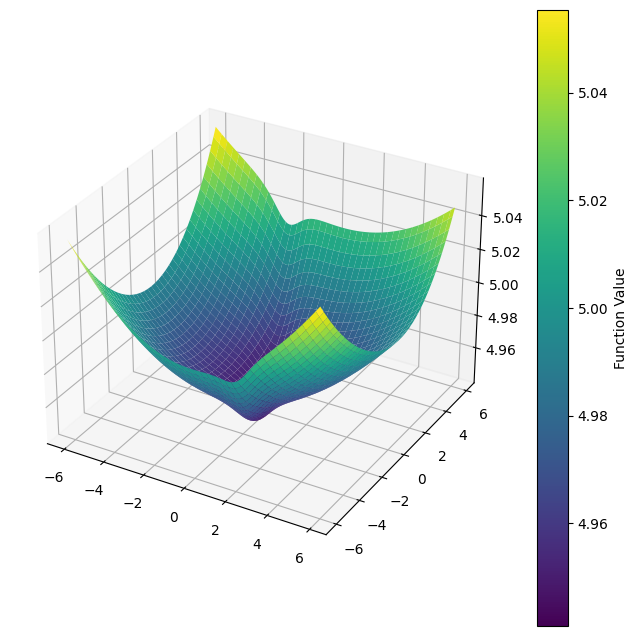

In [9]:
#-----------------------------------------------------------------------------
# Calculate 'true' output and network output for learned weights/biases
# for a range larger than the range used for training.


# Create a test dataset. 
## To do: Define x1_test and x2_text as described in the problem set. [-6.0, -5.9, -5.8, ..., 5.9, 6.0].
x1_test =  torch.arange(-6, 6, 0.1)
x2_test =  torch.arange(-6, 6, 0.1)
x1_grid_test, x2_grid_test = torch.meshgrid(x1_test, x2_test, indexing='ij') # For plotting 

x_test = torch.cartesian_prod(x1_test, x2_test).reshape(-1,2)
y_test = funToApprox(x_test)

x_test = x_test.to(device)
yhat = model(x_test)

## To do: Caluclate the loss.  

loss_test = emp_loss(yhat,y_test).mean()

print("\n")
print(f'Empirical loss for extended range: {loss_test.item()}')

# Plot the approximated function output.
## To do: Reshape yhat appropriately. 
# turn yhat to numpy array  
yhat = yhat.detach().numpy().reshape(x1_grid_test.shape)
fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(projection='3d')
surf = ax.plot_surface(x1_grid_test, x2_grid_test, yhat, cmap='viridis')
fig2.colorbar(surf, ax=ax, label='Function Value')



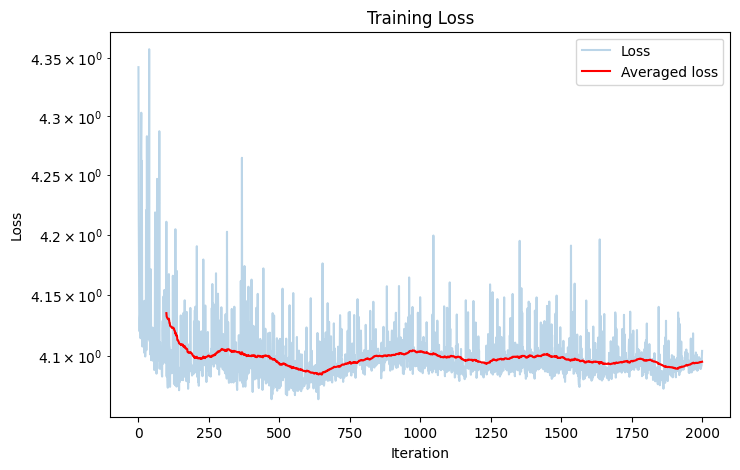

In [10]:
# Plot the loss to monitor the convergence. 

df = pd.DataFrame(loss_ep, columns=['loss'])

# Calculate a rolling average.
window_size = 100
df['rolling_loss'] = df['loss'].rolling(window=window_size).mean()

# Plot both the raw loss and the rolling average.
plt.figure(figsize=(8, 5))
plt.plot(df['loss'], alpha=0.3)  # Raw loss values in transparent color. 
plt.plot(df['rolling_loss'], color='r')  # Smoothed loss (rolling average) in bold red color.
plt.yscale('log')  
#plt.xscale('log') 
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend(['Loss', 'Averaged loss'])
plt.show()

In [11]:
torch.save(model, 'model-and-parameters-problem-03.pth')